# <center>Time Series Regression Analysis - </center>

## **Business Understanding**

### Introduction
Accurate sales forecasting is essential for maximising inventory, resource allocation, and decision-making processes in the dynamic world of retail. In this project, we delve into the realm of time series forecasting for store sales, aiming to provide a robust predictive model for Favorita, a leading Ecuadorian-based grocery retailer. By harnessing the power of data and advanced analytics, we seek to enhance Favorita's operations, improve customer satisfaction, and drive business growth.

### Business Objective
The main objective of this project is to develop a robust and accurate time series forecasting model that predicts store sales for a wide range of products across Favorita stores. By leveraging historical sales data and relevant supplementary information, the model aims to provide reliable forecasts that enable Favorita to optimize its inventory management, resource allocation, and marketing strategies. The successful implementation of this model will contribute to improved operational efficiency, enhanced decision-making, and increased profitability for the retailer.

### Business Goals
The key business goals of this project include:

- Improved Inventory Management: Accurate sales predictions will enable Favorita to manage inventory levels efficiently. 

- Enhanced Resource Allocation: With precise sales forecasts, Favorita can allocate human resources and logistics more effectively, ensuring that stores have adequate staff and supplies to meet customer demand.

- Marketing and Promotion Strategies: By understanding the impact of promotions on sales, Favorita can tailor its marketing strategies to boost sales during specific periods. 

- Optimized Financial Planning: Accurate sales predictions facilitate better financial planning and budgeting.


### Data Reqirements
To successfully achieve the objectives of this project and build an accurate time series forecasting model for store sales, the following data is required:

1.  Historical Sales Data
        
2.  Transaction Data
        

3.  Store Metadata 
       

4.  Oil Price Data 
        

5.  Holidays and Events Data 
        

#### Analytical Questions
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [1]:
### Install required packages

#Libraries for sql
# database connections
import pyodbc    
from dotenv import dotenv_values
import warnings 
warnings.filterwarnings('ignore')

#libraries for handling data
import pandas as pd
import numpy as np
#pd.set_option('display.max_rows', None)

##data visualizations
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

### Create a connection by accessing connection string with defined environment variables

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [3]:
# setup connection
connector = pyodbc.connect(connection_string)

In [4]:
# query the database
query = "SELECT * FROM dbo.oil"
df_1 = pd.read_sql(query,connector)

In [5]:
# Now the sql query to get the data is what what you see below. 
query = "SELECT * FROM dbo.oil"
query1 = "SELECT * FROM dbo.holidays_events"
query2 = "SELECT * FROM dbo.stores"

In [6]:
# Read all data from different sources
oil_df = pd.read_sql(query, connector)
holidays_events_df = pd.read_sql(query1, connector)
stores_df = pd.read_sql(query2, connector)
transactions_df = pd.read_csv('./Dataset/transactions.csv')
train_df = pd.read_csv('./Dataset/train.csv')
test_df = pd.read_csv('./Dataset/test.csv')

## **Data Understanding**

### Data Collection
Data for this project will be collected from 3 places, a database, OneDrive and GitHub

### Data Description
The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models

**File Descriptions and Data Field Information**

train.csv

- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

- **store_nbr** identifies the store at which the products are sold.

- **family** identifies the type of product sold.

- **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

test.csv

- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.

- The dates in the test data are for the 15 days after the last date in the training data.

transaction.csv

- Contains date, store_nbr and transaction made on that specific date.

sample_submission.csv

- A sample submission file in the correct format.

stores.csv

- Store metadata, including city,state, type, and cluster.

- cluster is a grouping of similar stores.

oil.csv

- **Daily oil price** which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

holidays_events.csv

- Holidays and Events, with metadata

Additional holidays are days added, a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

Additional Notes

- Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [7]:
# Display the dataframe
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [8]:
# Display the dataframe
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
# Display the dataframe
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
# Display the dataframe
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [11]:
# Display the dataframe
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [12]:
# Display the dataframe
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


**Shape of the datasets**

In [13]:
# Print out the shapes of all the datasets
print(f"Train Dataset: {train_df.shape}")
print(f"Test Datasets: {test_df.shape}")
print("Shapes of Each Dataset:")
print(f"Holiday Events Dataset: {holidays_events_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")
print(f"Transactions Dataset: {transactions_df.shape}")

Train Dataset: (3000888, 6)
Test Datasets: (28512, 5)
Shapes of Each Dataset:
Holiday Events Dataset: (350, 6)
Oil Dataset: (1218, 2)
Stores Dataset: (54, 5)
Transactions Dataset: (83488, 3)


The train dataset contains 3,000,888 rows and 6 columns while the test dataset contains 28,512 rows and 5 columns.

The train dataset is significantly larger than the test dataset in terms of the number of rows. This is expected, as the train dataset is usually larger to provide sufficient data for model training.
The Holiday Events dataset contains 350 rows and 6 columns. This dataset provides information about various holidays and events.

The Oil dataset consists of 1,218 rows and 2 columns. This dataset includes information about the daily price of oil.

The Stores dataset contains 54 rows and 5 columns. This dataset provides details about different stores, such as their locations, types, and clusters.

The Transactions dataset contains 83,488 rows and 3 columns. This dataset contains information about the number of transactions made at each store on specific dates.

**Columns of the datasets**

In [14]:
# Get the column information of each dataset
# Function to display column information of the datasets
def column_info(dataset_name, dataset):
    print(f"Data types for the {dataset_name} dataset:")
    print(dataset.info())
    print('='*58)

In [15]:
# Column information of all the datasets
column_info('Train', train_df)
print()
column_info('Test', test_df)
print()
column_info('Holiday events', holidays_events_df)
print()
column_info('Oil', oil_df)
print()
column_info('Stores', stores_df)
print()
column_info('Transactions', transactions_df)

Data types for the Train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Data types for the Test dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None

Data types for the Holiday events dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex:

The 'date' columns in all the datasets are objects and will be promptly converted to datetime format since we dealing with a Time Series

#### Converting the 'date' column to datetime format

In [16]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
train_df['date'] = pd.to_datetime(train_df['date'])

# Test dataset
test_df['date'] = pd.to_datetime(test_df['date'])

# Oil dataset
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Holiday Events dataset
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

# Transactions dataset
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


#### Checking for Missing Values in The Datasets

In [18]:
# Checking for missing values in the datasets
# Function to display summary statistics of the datasets
def missing_values(dataset_name, dataset):
    print(f"Missing {dataset_name} dataset :")
    print(dataset.isnull().sum())
    print('='*58)

In [19]:
# Missing values of all the datasets
missing_values('Train', train_df)
print()
missing_values('Test', test_df)
print()
missing_values('Holiday events', holidays_events_df)
print()
missing_values('Oil', oil_df)
print()
missing_values('Stores', stores_df)
print()
missing_values('Transactions', transactions_df)

Missing Train dataset :
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing Test dataset :
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing Holiday events dataset :
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing Oil dataset :
date           0
dcoilwtico    43
dtype: int64

Missing Stores dataset :
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing Transactions dataset :
date            0
store_nbr       0
transactions    0
dtype: int64


### Summary statistics of the datasets

In [20]:
# Checking for the summary statistics of the datasets 
# Function to display summary statistics of the datasets
def summary_stats(dataset_name, dataset):
    print(f"{dataset_name} dataset summary statistics :")
    print(dataset.describe())
    print('='*80)

In [21]:
# Summary statistics of all the datasets
summary_stats('Train', train_df)
print()
summary_stats('Test', test_df)
print()
summary_stats('Holiday events', holidays_events_df)
print()
summary_stats('Oil', oil_df)
print()
summary_stats('Stores', stores_df)
print()
summary_stats('Transactions', transactions_df)

Train dataset summary statistics :
                 id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662819e+05                            NaN  1.558579e+01   

              sales   onpromotion  
count  3.000888e+06  3.000888e+06  
mean   3.577757e+02  2.602770e+00  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    1.100000e+01  0.000000e+00  
75%    1.958473e+02  0.000000e+00  
max    1.247170e+05  7.410000e+02  
std    1.101998e+03  1.221888e+01  

Test dataset summary statis

#### Further Exploring the Train Dataset

In [22]:
# Creating a copy to ensure we can retrive the orginal dataframe incase of an error during our analysis
train_df1 = train_df.copy()
train_df2 = train_df.copy()

In [23]:
train_df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [24]:
# Check for duplicates
train_df1.duplicated().sum()

0

In [25]:
# Drop the 'id' column since it does not add anything to our analysis
train_df1.drop('id', axis=1, inplace=True)

In [26]:
# Set 'date' as index to allow for better time series analysis
#train_df1.set_index('date')

In [27]:
train_df1.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


**Check for completeness of data or missing values**

In [28]:
train_df1['date'].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00',
 ...
 '2017-08-06 00:00:00', '2017-08-07 00:00:00', '2017-08-08 00:00:00',
 '2017-08-09 00:00:00', '2017-08-10 00:00:00', '2017-08-11 00:00:00',
 '2017-08-12 00:00:00', '2017-08-13 00:00:00', '2017-08-14 00:00:00',
 '2017-08-15 00:00:00']
Length: 1684, dtype: datetime64[ns]

In [29]:
# Check for earliest and latest date
actual_date = train_df1['date'].min(), train_df1['date'].max()
print(f'Start date of data: {actual_date[0]}\nEnd date of data: {actual_date[1]}')

Start date of data: 2013-01-01 00:00:00
End date of data: 2017-08-15 00:00:00


In [30]:
date_range = pd.date_range(start=train_df1['date'].min(), end=train_df1['date'].max(), freq='D')
date_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [31]:
# The date_range for the start and end is supposed to be
date_range.size

1688

In [32]:
train_df1['date'].unique().shape

(1684,)

In [33]:
# Find missing days from date column of the train df by using the differnce dates
missing_days = date_range.difference(train_df1['date'])
missing_days

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

**Fill in values for missing date by the family category**

In [34]:
families = train_df1['family'].unique()
print(f'Unique families in the train data is {families.size}')
families

Unique families in the train data is 33


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [35]:
store_nbr = train_df1['store_nbr'].unique()
print(f'Unique stores in the train data is {store_nbr.size}')
store_nbr

Unique stores in the train data is 54


array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

**Key Insights on Data Completenes**
1. There are no duplicates or null in the train data
2. The date range between hte start and end date means 1688, but there are only 1684 days the train data 
3. From the above we con authouritatively conclude that 4 days are missing
4. We need to add these 4 days to the dataframe and fill/interpolate the sales values for the 4 missing days, because the sales for any given day is categorized into 
- Families
- Days 
- Store_nbr

**Plan of Acton**
1. Create the families for the missing days for each store
2. Since there are 33 families, 54 stores and 4 missing days. we will generate 7,128 new data points
- 33 *54 *4 (see unique values of these columns)
- Use product class from itertools

**Ceate new data points for the missing days**

In [36]:
from itertools import product

In [37]:
# Use the product class to create data points for the missing dates
missing_data_points = product(missing_days, store_nbr, families)

# Create a dataframe from product object generated
new_data = pd.DataFrame(data=missing_data_points, columns=["date", "store_nbr", "family"])

# Display dataframe
new_data.head()

,date,store_nbr,family
0,2013-12-25,1,AUTOMOTIVE
1,2013-12-25,1,BABY CARE
2,2013-12-25,1,BEAUTY
3,2013-12-25,1,BEVERAGES
4,2013-12-25,1,BOOKS


In [38]:
df = pd.concat([train_df1, new_data], axis=0)
df.set_index('date', inplace=True)
df.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0.0
2013-01-01,1,BABY CARE,0.0,0.0
2013-01-01,1,BEAUTY,0.0,0.0
2013-01-01,1,BEVERAGES,0.0,0.0
2013-01-01,1,BOOKS,0.0,0.0


In [39]:
# Check null values again and the new generated data points should ave the sales and onpromotion columns having null values 
df.isna().sum()

store_nbr         0
family            0
sales          7128
onpromotion    7128
dtype: int64

In [40]:
# Double check to make sure there no missing days
missing_days = set(date_range) - set(df.index.unique())
missing_days

set()

In [41]:
# Checking the data shape again
df.shape

(3008016, 4)

In [42]:
# Change NaN values for the sales and onpromotion columns to 0
df['sales'] = df['sales'].fillna(0)
df['onpromotion'] = df['onpromotion'].fillna(0)


In [43]:
# Verify the changes 
df.isnull().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [44]:
# Sort date column to be in ascending order from start date to end date  ( end date is 15th September 2017)
df.sort_index(inplace=True)
df

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0.0
2013-01-01,42,CELEBRATION,0.000,0.0
2013-01-01,42,BREAD/BAKERY,0.000,0.0
2013-01-01,42,BOOKS,0.000,0.0
2013-01-01,42,BEVERAGES,0.000,0.0
...,...,...,...,...
2017-08-15,25,POULTRY,172.517,0.0
2017-08-15,25,PLAYERS AND ELECTRONICS,3.000,0.0
2017-08-15,25,PET SUPPLIES,3.000,0.0


**Univariate Analysis**

In [45]:
# Print unique values for each columns
for column in df.columns:
    print(f'Column Name: {column}\n')
    print(f'Number of Unique Values: {df[column].unique().size}\n' )
    print(f'{df[column].unique()}')
    print('=' * 80)

Column Name: store_nbr

Number of Unique Values: 54

[ 1 42 41 43 40  4 45 44 46 36 35 37 34 39 38 54  6 53 52  9  8  7 48 49
 47 51 50  5 33 18 17 19 16 15 20  2 21 11 10 12 14 13  3 29 30 28 32 31
 23 24 22 27 26 25]
Column Name: family

Number of Unique Values: 33

['AUTOMOTIVE' 'CELEBRATION' 'BREAD/BAKERY' 'BOOKS' 'BEVERAGES' 'BEAUTY'
 'BABY CARE' 'SEAFOOD' 'SCHOOL AND OFFICE SUPPLIES' 'PRODUCE'
 'PREPARED FOODS' 'POULTRY' 'PLAYERS AND ELECTRONICS' 'PET SUPPLIES'
 'PERSONAL CARE' 'MEATS' 'MAGAZINES' 'LIQUOR,WINE,BEER' 'LINGERIE'
 'LAWN AND GARDEN' 'LADIESWEAR' 'HOME CARE' 'HOME APPLIANCES' 'CLEANING'
 'DAIRY' 'DELI' 'EGGS' 'HOME AND KITCHEN II' 'HOME AND KITCHEN I'
 'HARDWARE' 'GROCERY II' 'GROCERY I' 'FROZEN FOODS']
Column Name: sales

Number of Unique Values: 379610

[   0.      15.     700.    ...  382.93   385.94  1269.174]
Column Name: onpromotion

Number of Unique Values: 362

[  0.   3.   5.   1.  56.  20.  19.   2.   4.  18.  17.  12.   6.  10.
   7.   9.  50.   8.  16.  51

In [46]:
# Change the format of the sales column from scientofic notation
pd.options.display.float_format = '{:.2f}'.format

In [47]:
# Check for skewness
df.drop('family', axis=1).skew().rename('Skewness').reset_index()

,index,Skewness
0,store_nbr,0.00
1,sales,7.37
2,onpromotion,11.18


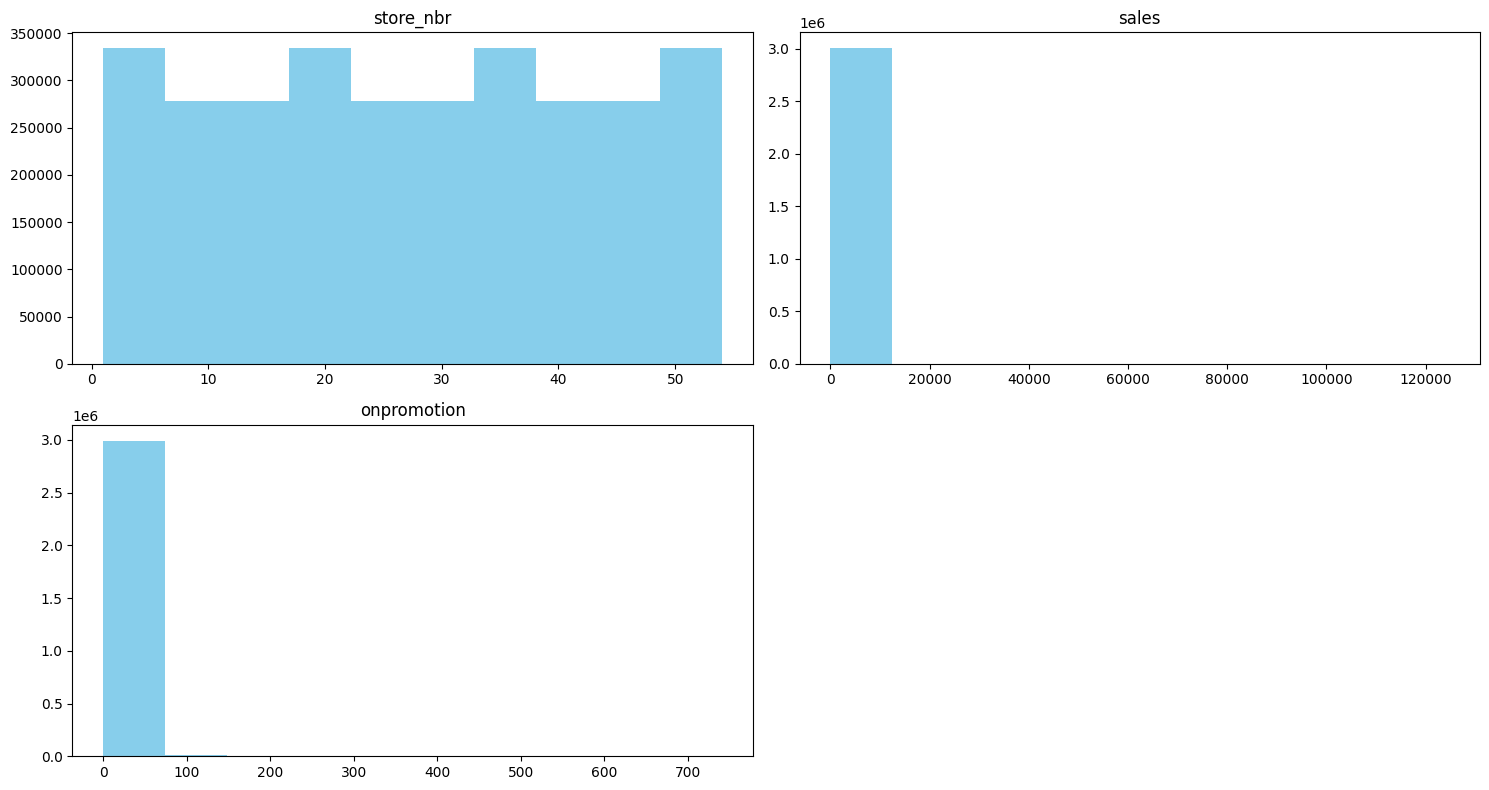

In [48]:
df.hist(figsize=(15, 8), color='skyblue', grid=False)
plt.tight_layout()
plt.show()

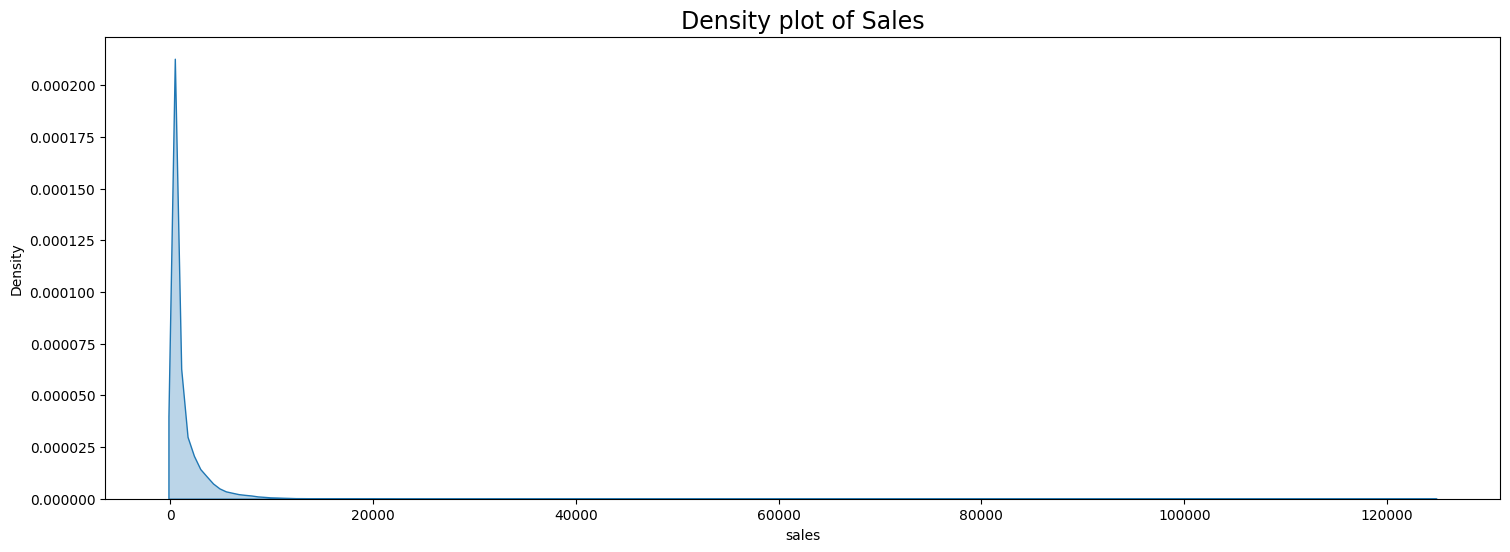

In [49]:
# Density plot of sales
plt.figure(figsize=(18, 6))
sns.kdeplot(df['sales'], fill=True, alpha=0.3)
plt.title('Density plot of Sales', fontsize=17)
plt.show()

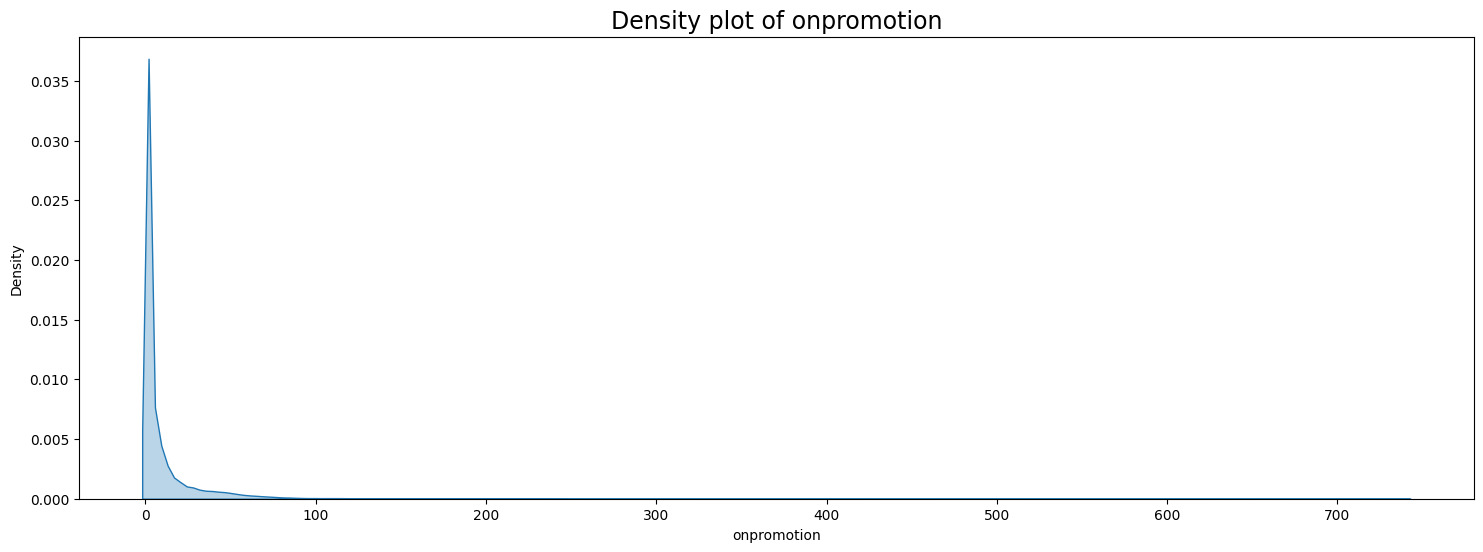

In [50]:
# Density plot of onpromtion
plt.figure(figsize=(18, 6))
sns.kdeplot(df['onpromotion'], fill=True, alpha=0.3)
plt.title('Density plot of onpromotion', fontsize=17)
plt.show()

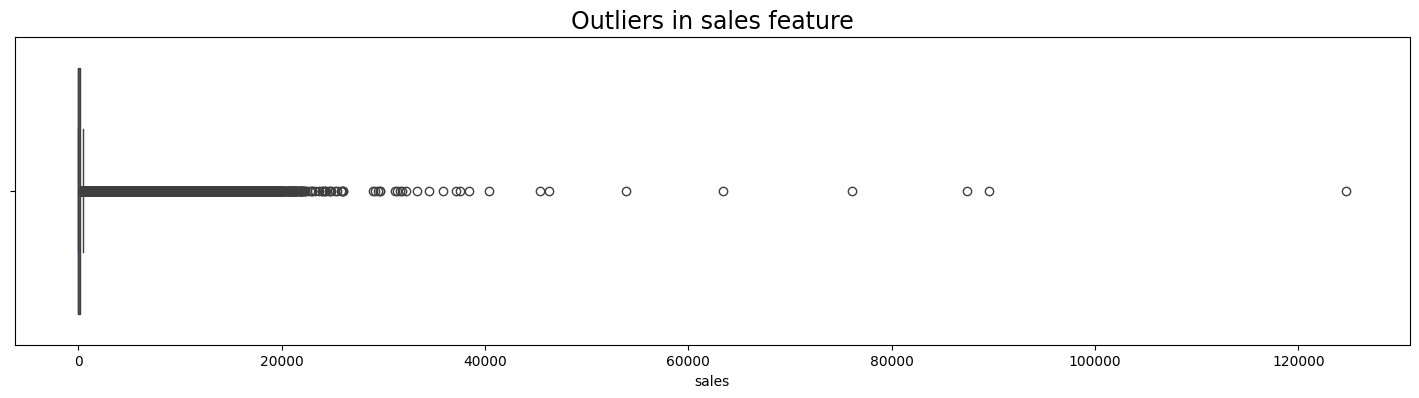

In [51]:
# Check for outliers in sales column
plt.figure(figsize=(18, 4))
sns.boxplot(df['sales'], orient='h')
plt.title('Outliers in sales feature', fontsize=17)
plt.show()

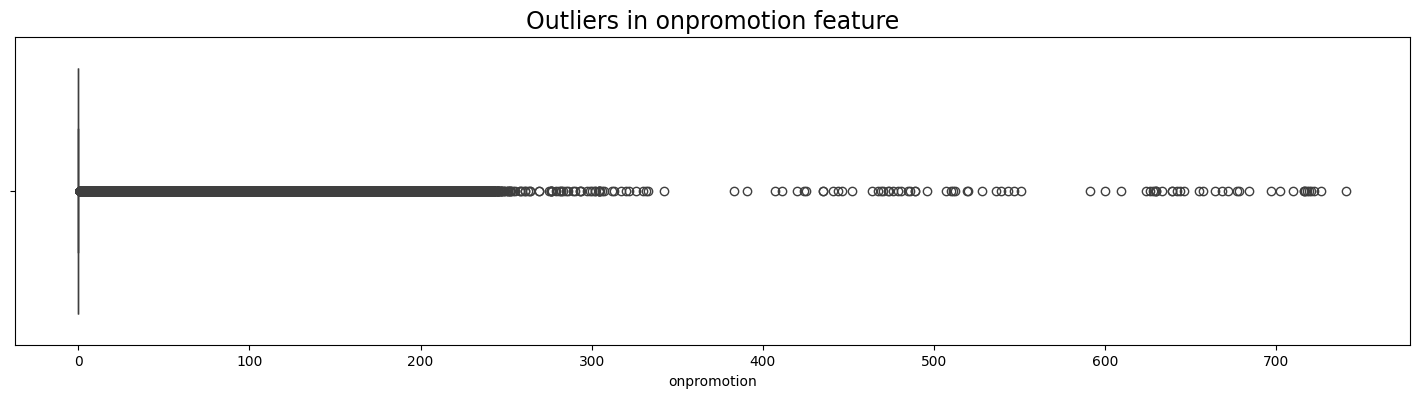

In [52]:
# Check for outliers in onpromotion column
plt.figure(figsize=(18, 4))
sns.boxplot(df['onpromotion'], orient='h')
plt.title('Outliers in onpromotion feature', fontsize=17)
plt.show()

**Bivariate Analysis**

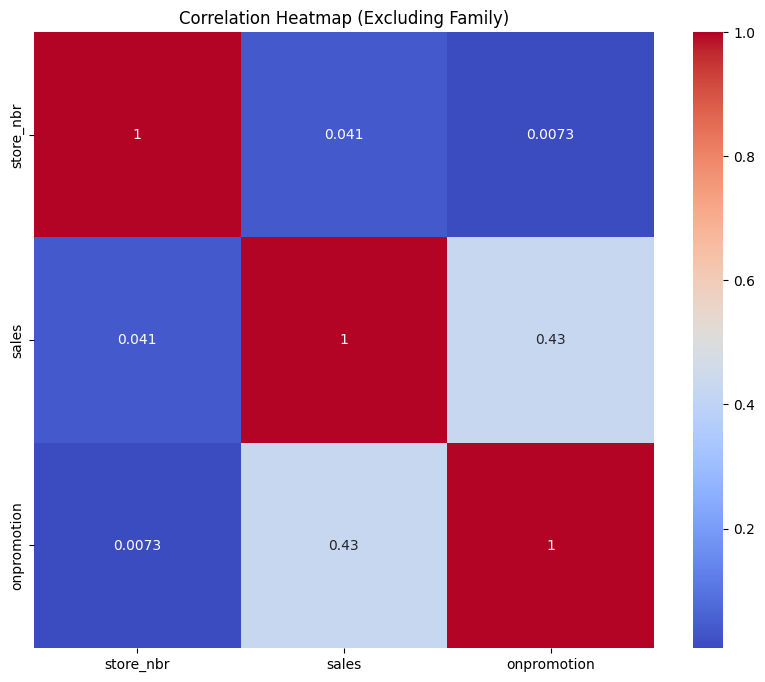

In [53]:
# Multi Variate Analysis
# Exclude the 'family' column
corr_matrix = df.drop(columns=['family']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Excluding Family)')
plt.show()

In [54]:
# Create New features to check for better correlation -- Feature Creation
def create_new_features(df):
    df['month_name'] = df.index.month_name()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day'] = df.index.dayofweek
    return df

df = create_new_features(df)
df

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1
...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,1
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,1
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,1


In [55]:
#correlation_without_date = df.drop(['family', 'month', 'month_name', 'year', 'day'], axis=1).corr()
#correlation_without_date

In [56]:
#plt.figure(figsize=(12, 6))
#sns.heatmap(correlation_without_date, annot=True, cmap='coolwarm')
#plt.title('Correlation Matrix of Numeric Features', fontsize=15)
#plt.show()

In [57]:
# Create a correlation heatmap
correlation = df.drop(['family', 'month_name'], axis=1).corr()
correlation

,store_nbr,sales,onpromotion,month,year,day
store_nbr,1.00,0.04,0.01,0.00,-0.00,-0.00
sales,0.04,1.00,0.43,0.02,0.08,0.04
onpromotion,0.01,0.43,1.00,0.02,0.20,-0.00
month,0.00,0.02,0.02,1.00,-0.14,-0.00
year,-0.00,0.08,0.20,-0.14,1.00,0.00
day,-0.00,0.04,-0.00,-0.00,0.00,1.00


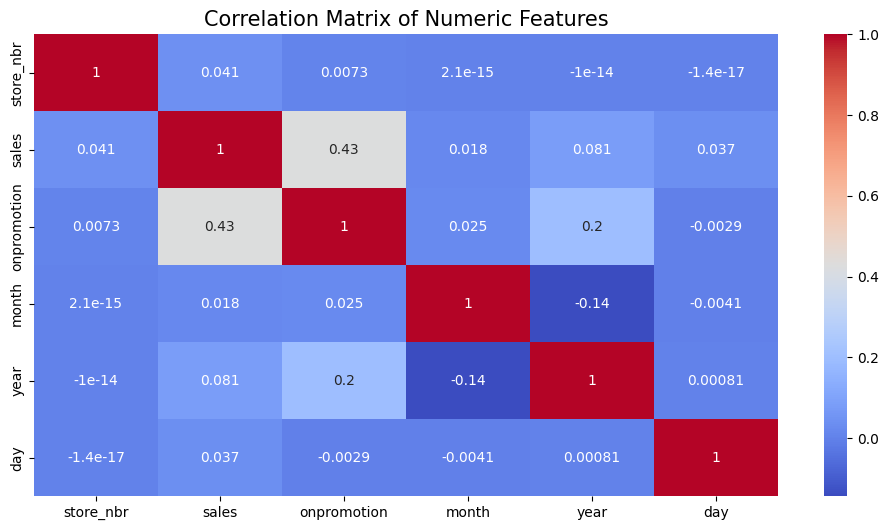

In [58]:

plt.figure(figsize=(12, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features', fontsize=15)
plt.show()

In [59]:
import calplot

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


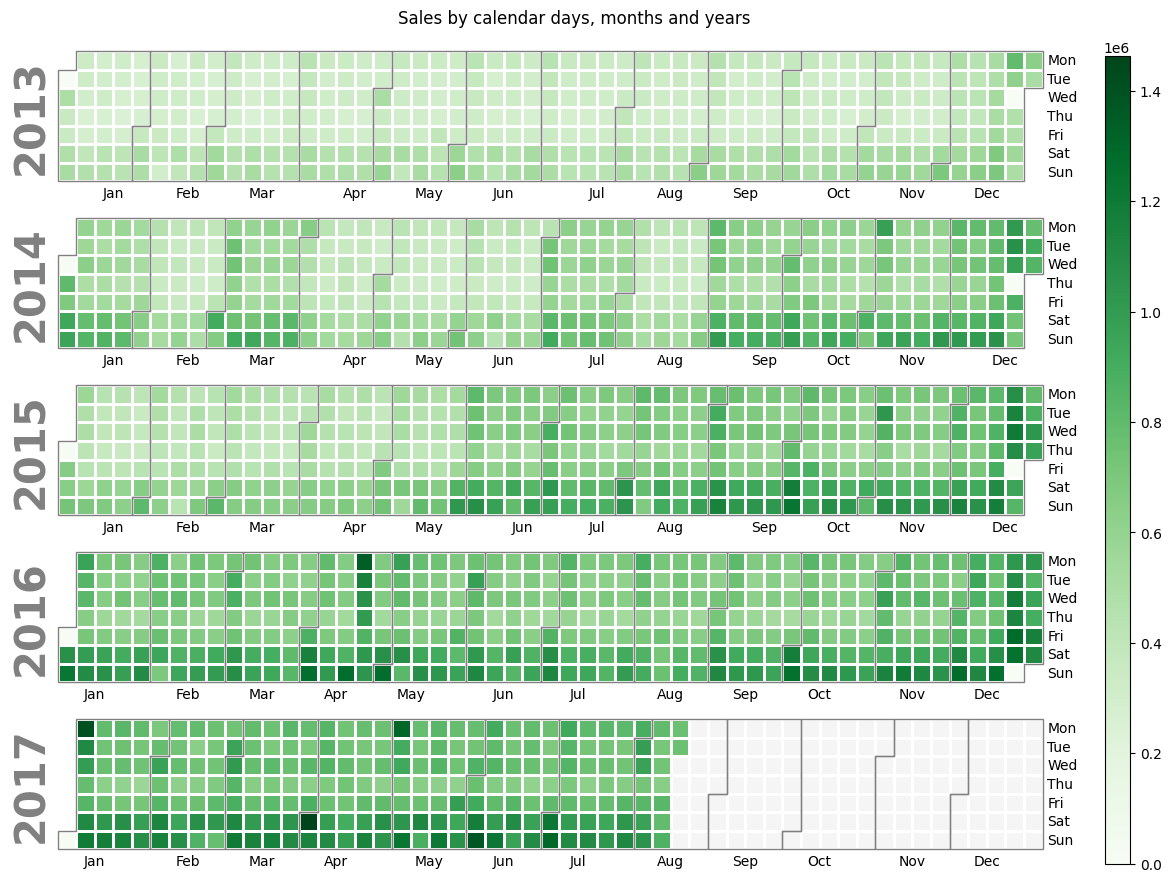

In [60]:
# Plot a calendar heatmap for daily data
calplot.calplot(df['sales'], how='sum', cmap='Greens', suptitle='Sales by calendar days, months and years')
plt.show()

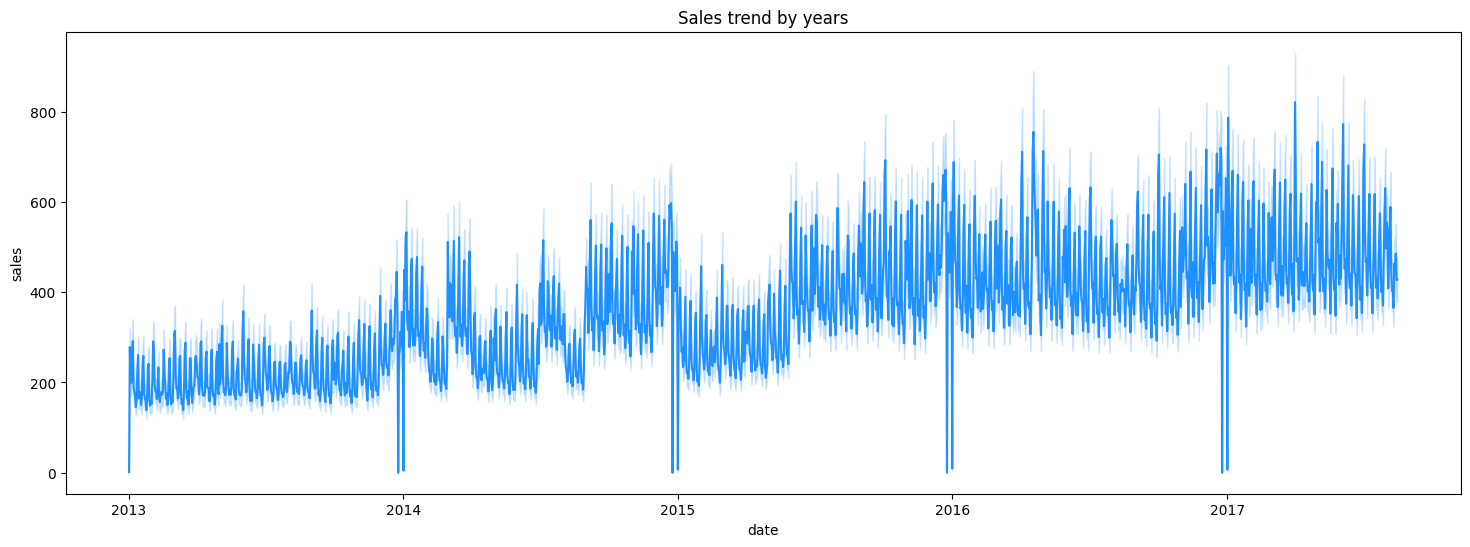

In [61]:
# Sales trends 
plt.figure(figsize=(18, 6))
sns.lineplot(data=df, x=df.index, y='sales', color='dodgerblue')
plt.title('Sales trend by years')
plt.show()

**Decomposition**

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

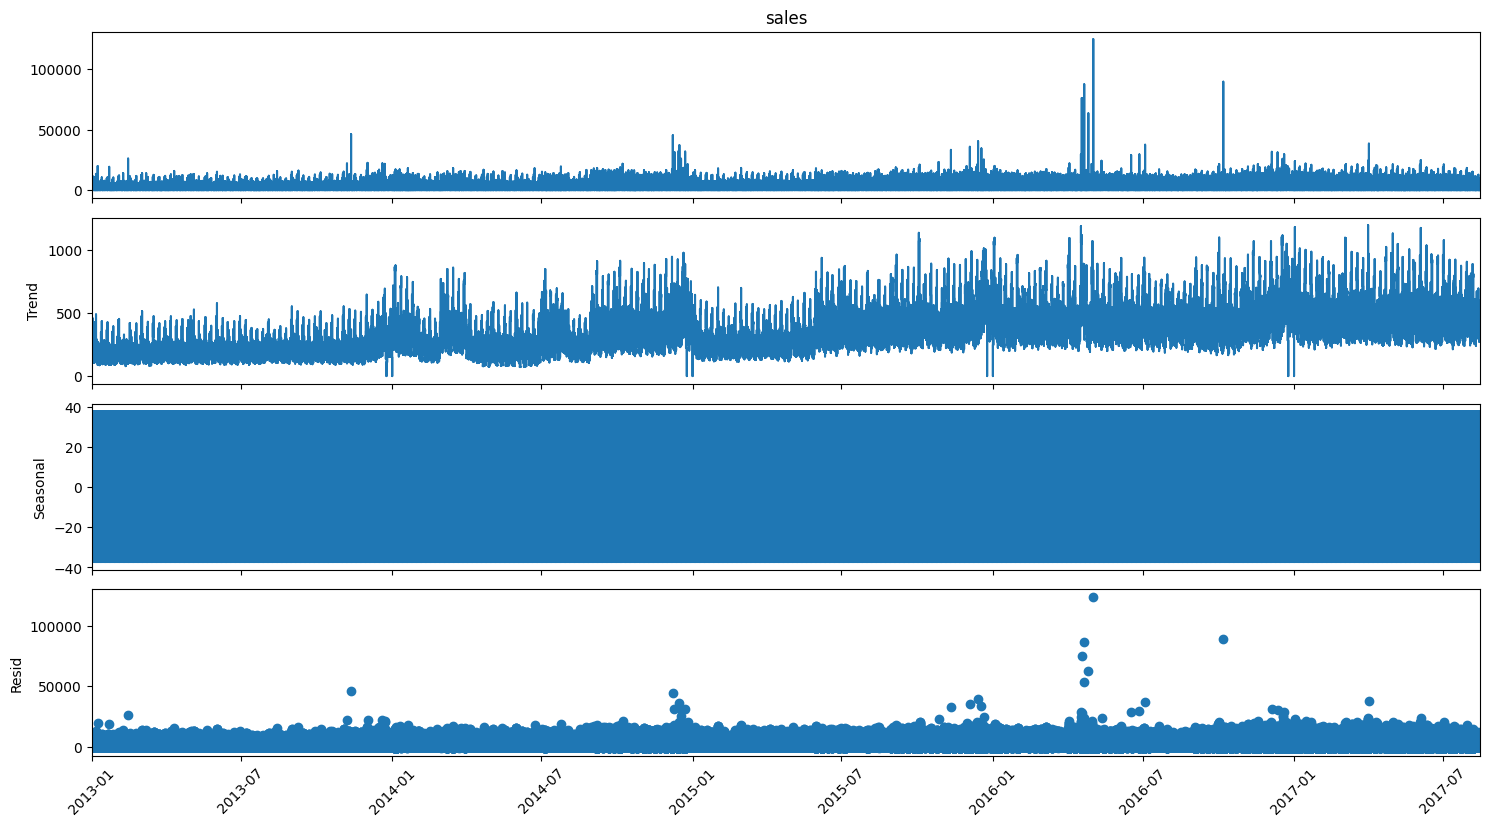

In [63]:
# Decompose the time series into trend, seasonality and residual
result = seasonal_decompose(df['sales'], model='additive', period=365)
plt.rcParams.update({'figure.figsize' : (15, 8)})
result.plot()
plt.xticks(rotation=45)
plt.show()

In [64]:
# Create a new DataFrame to store the components
decomposition_df = pd.DataFrame({
    'Trend': result.trend,
    'Seasonality': result.seasonal,
    'Residual': result.resid,
    'Observed': result.observed
})

# Display the new DataFrame
decomposition_df

,Trend,Seasonality,Residual,Observed
date,,,,
2013-01-01,NaN,9.23,NaN,0.00
2013-01-01,NaN,-3.24,NaN,0.00
2013-01-01,NaN,-5.17,NaN,0.00
2013-01-01,NaN,-10.93,NaN,0.00
2013-01-01,NaN,-5.84,NaN,0.00
...,...,...,...,...
2017-08-15,NaN,13.01,NaN,172.52
2017-08-15,NaN,13.57,NaN,3.00
2017-08-15,NaN,-7.78,NaN,3.00


In [65]:
decomposition_df.tail(1000)

,Trend,Seasonality,Residual,Observed
date,,,,
2017-08-15,549.31,-18.79,-312.64,217.89
2017-08-15,549.15,-3.12,830.97,1377.00
2017-08-15,551.85,-9.34,814.49,1357.00
2017-08-15,552.01,8.28,-544.29,16.00
2017-08-15,552.34,-13.90,166.36,704.80
...,...,...,...,...
2017-08-15,NaN,13.01,NaN,172.52
2017-08-15,NaN,13.57,NaN,3.00
2017-08-15,NaN,-7.78,NaN,3.00


In [66]:
df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1


**Stationarity Testing**

In [67]:
# Resample and calculate the mean only on the 'sales column
df_downsampled = df[['sales']].resample('W').mean()

# Check if there is NaN values and handle them appropriately
df_downsampled.fillna(0, inplace=True)

# Display the new DataFrame
df_downsampled

,sales
date,
2013-01-06,206.84
2013-01-13,190.29
2013-01-20,189.84
2013-01-27,182.15
2013-02-03,198.56
...,...
2017-07-23,460.50
2017-07-30,474.73
2017-08-06,513.88


In [68]:
from statsmodels.tsa.stattools import adfuller

In [69]:
# # Use the ADF calculate stationarity in sales 
result = adfuller(df_downsampled['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print('Data is stationary')
else:
    print('Data is not stationary')

ADF Statistic: -1.4817509177560242
p-value: 0.5425188110982653
Data is not stationary


In [70]:
result

(-1.4817509177560242,
 0.5425188110982653,
 13,
 228,
 {'1%': -3.4593607492757554,
  '5%': -2.8743015807562924,
  '10%': -2.5735714042782396},
 2278.6898598939215)

**Visualizing stationarity using Rolling Statistics**

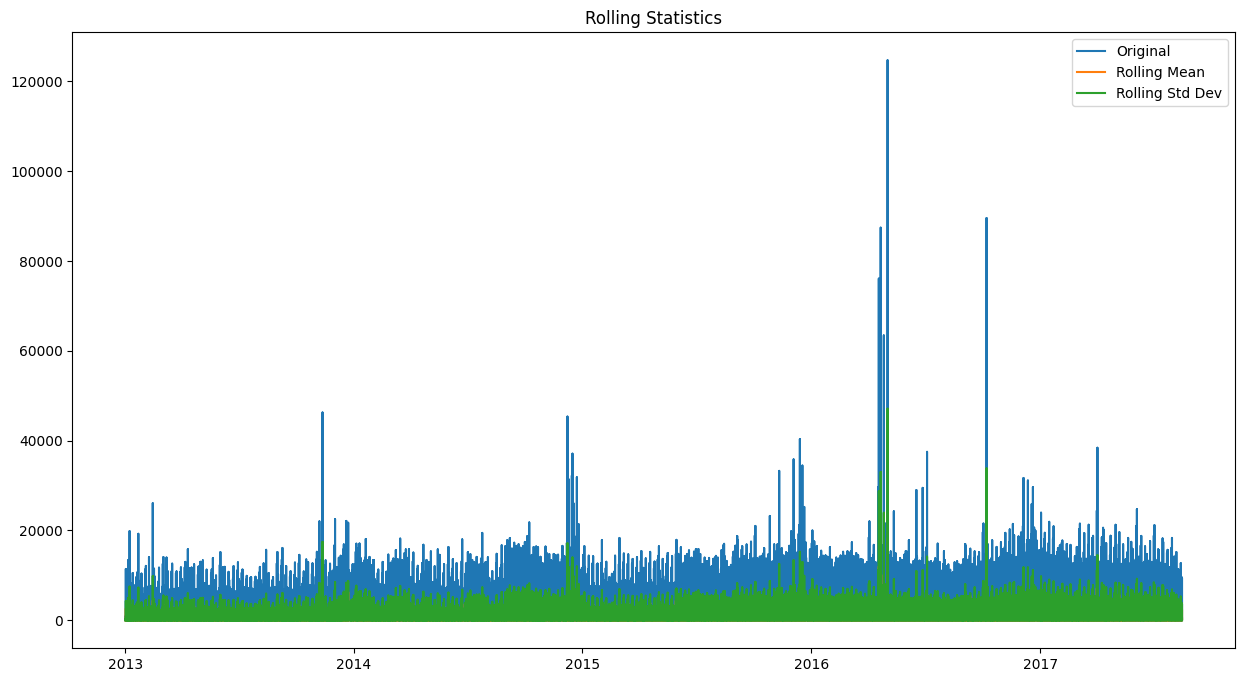

In [71]:
# Rolling mean and standard deviation
rolling_mean = df['sales'].rolling(window=7).mean()
rolling_std = df['sales'].rolling(window=7).std()

plt.plot(df['sales'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std Dev')
plt.legend(loc='best')
plt.title('Rolling Statistics')
plt.show()

**Key Insights - Visualization**
1. The sales and onpromtion columns are heavily skewed with a lot of outliers
2. The data is not stationary - meaning it does not maintain a constant mean, variance and co-variance over time

**Answering Analytical Questions**

**1. Is the train dataset complete (has all the required dates)?**

- The question was answered during the checking for data completeness phase early on. 
- There were 4 missing days in the train data namely; 25-01-2013, 25-01-2014, 25-01-2015, 25-01-2016

**2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?**

In [72]:
sales_df = df.groupby('date')['sales'].sum().reset_index()
sales_df

,date,sales
0,2013-01-01,2511.62
1,2013-01-02,496092.42
2,2013-01-03,361461.23
3,2013-01-04,354459.68
4,2013-01-05,477350.12
...,...,...
1683,2017-08-11,826373.72
1684,2017-08-12,792630.54
1685,2017-08-13,865639.68
1686,2017-08-14,760922.41


In [74]:
closed_days = sales_df[sales_df['sales'] == 0]
closed_days

,date,sales
358,2013-12-25,0.00
723,2014-12-25,0.00
1088,2015-12-25,0.00
1454,2016-12-25,0.00


In [75]:
# Remove days that the store was closed - closed_days
opened_days = sales_df.drop(closed_days.index)
opened_days.sort_values(by='sales')

,date,sales
0,2013-01-01,2511.62
365,2014-01-01,8602.07
1461,2017-01-01,12082.50
730,2015-01-01,12773.62
1095,2016-01-01,16433.39
...,...,...
1581,2017-05-01,1306699.37
1203,2016-04-18,1345920.60
1615,2017-06-04,1376511.52
1462,2017-01-02,1402306.37


In [77]:
# Decompose the date column into Year, Year-Month, Month and Day to facilitate deep analysis
# year
opened_days['year'] = opened_days.date.dt.year

# year-month
opened_days['year-month'] = opened_days['date'].apply(lambda x : x.strftime('%Y-%m'))

# month
opened_days['month'] = opened_days.date.dt.month

# dayopened_days
opened_days['day'] = sales_df.date.dt.day

In [78]:
# Group by year and find the date with max and min sales
max_sales_dates = opened_days.loc[opened_days.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]
min_sales_dates = opened_days.loc[opened_days.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]

full_dates = min_sales_dates.merge(max_sales_dates, on=['year'])

full_dates.rename(columns={'date_x': 'min_date', 'sales_x': 'min_sales', 'date_y': 'max_date', 'sales_y': 'max_sales'},  inplace=True)

full_dates

,year,min_date,min_sales,max_date,max_sales
0,2013,2013-01-01,2511.62,2013-12-23,792865.28
1,2014,2014-01-01,8602.07,2014-12-23,1064977.97
2,2015,2015-01-01,12773.62,2015-10-04,1234130.94
3,2016,2016-01-01,16433.39,2016-04-18,1345920.60
4,2017,2017-01-01,12082.50,2017-04-01,1463083.96


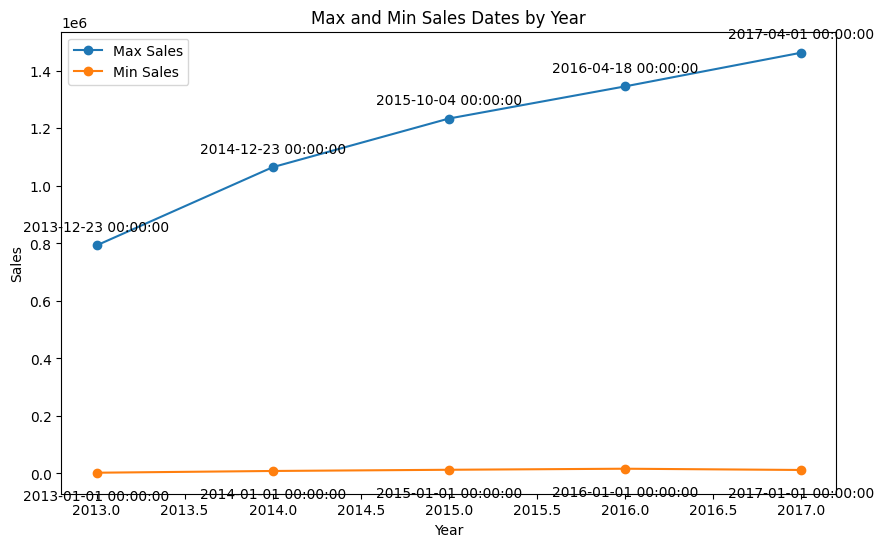

In [80]:
# Plot max and min sales dates
plt.figure(figsize=(10, 6))
plt.plot(full_dates['year'], full_dates['max_sales'], marker='o', label='Max Sales')
plt.plot(full_dates['year'], full_dates['min_sales'], marker='o', label='Min Sales')

# Annotate max sales dates
for i, txt in enumerate(full_dates['max_date']):
    plt.annotate(txt, (full_dates['year'][i], full_dates['max_sales'][i]), textcoords="offset points", xytext=(0,10), ha='center')

# Annotate min sales dates
for i, txt in enumerate(full_dates['min_date']):
    plt.annotate(txt, (full_dates['year'][i], full_dates['min_sales'][i]), textcoords="offset points", xytext=(0,-20), ha='center')

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Max and Min Sales Dates by Year')
plt.legend()
plt.grid(False)
plt.show()

**3. Compare the sales for each month across the years and determine which month of which year had the highest sales.**


In [182]:
# Get the largest sales days
largest_sales_days = opened_days.nlargest(1, 'sales')
largest_sales_days

,date,sales,year,year-month,month,day
1551,2017-04-01,1463083.96,2017,2017-04,4,1


In [184]:
# Get the lowest sales days
lowest_sales_days = opened_days.nsmallest(1, 'sales')
lowest_sales_days

,date,sales,year,year-month,month,day
0,2013-01-01,2511.62,2013,2013-01,1,1


In [186]:
# Merge the 2 dataframe
sales_levels = pd.concat([largest_sales_days, lowest_sales_days])
sales_levels

,date,sales,year,year-month,month,day
1551,2017-04-01,1463083.96,2017,2017-04,4,1
0,2013-01-01,2511.62,2013,2013-01,1,1


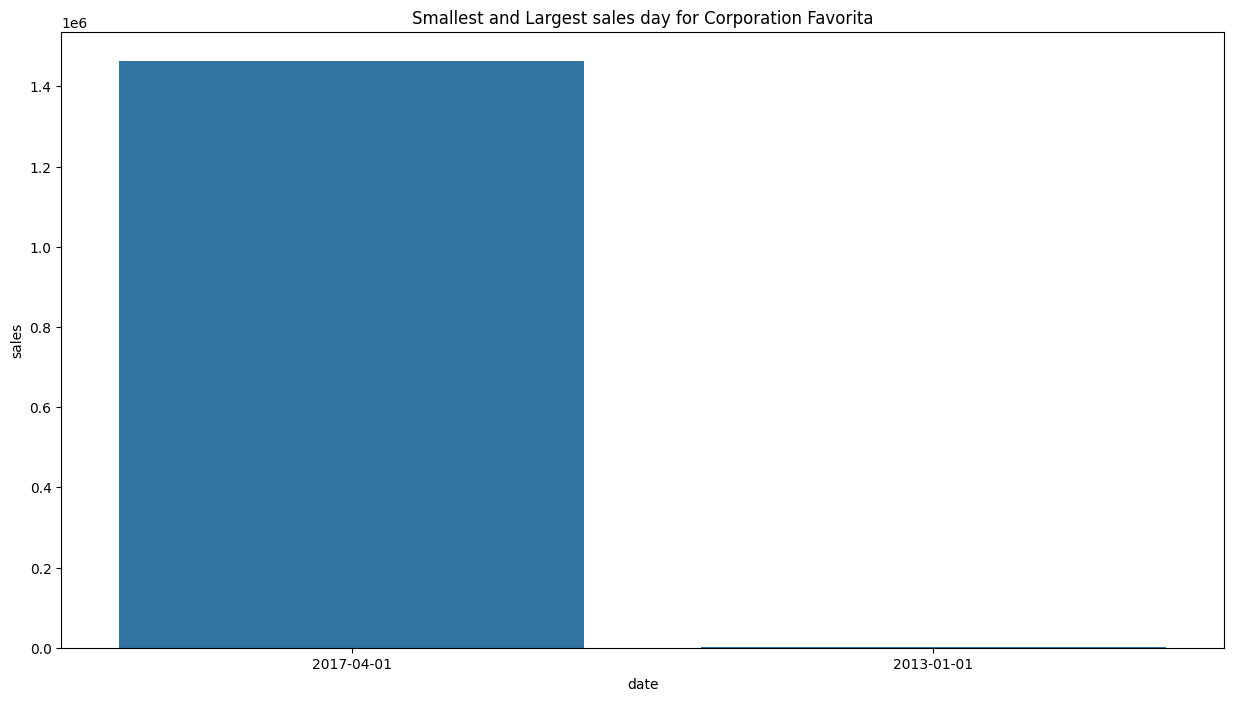

In [188]:
# Vusualize the results
sns.barplot(x='date', y='sales', data=sales_levels)
plt.title('Smallest and Largest sales day for Corporation Favorita')
plt.show()

**4. Did the earthquake impact sales?**


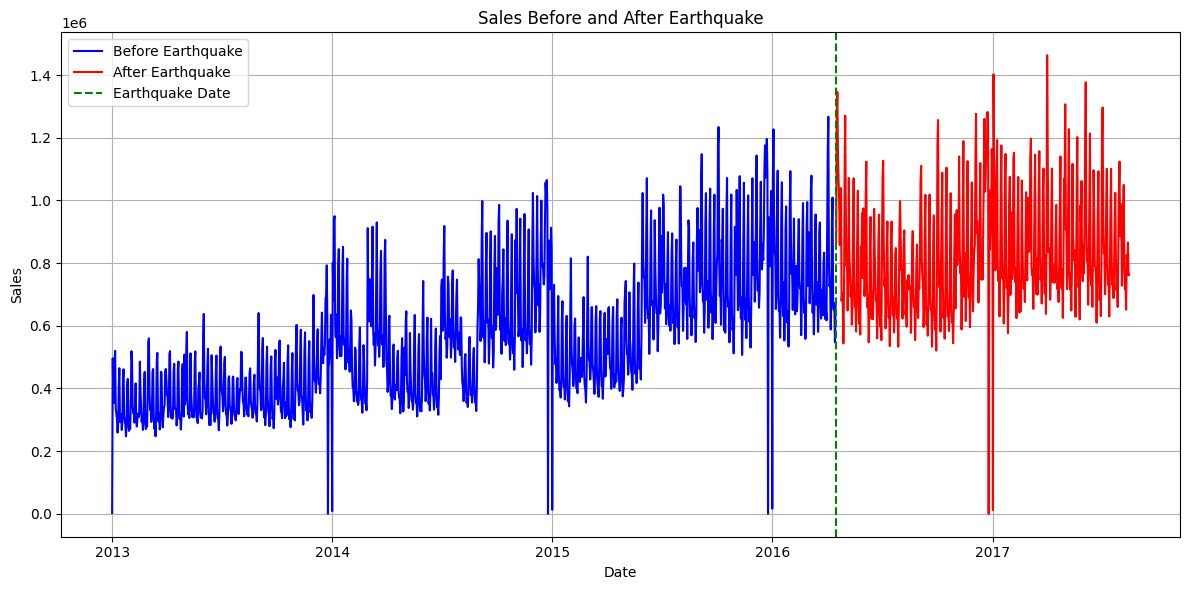

In [181]:
# Filter data for the period before and after the earthquake
earthquake_date = "2016-04-16"
post_earthquake = sales_df[sales_df['date'] >= earthquake_date]
pre_earthquake = sales_df[sales_df['date'] < earthquake_date]

plt.figure(figsize=(12,6))
# Spliting the data into pre and post-earthquake periods
sns.lineplot(data=pre_earthquake, x='date', y='sales', label='Before Earthquake', color='blue')
sns.lineplot(data=post_earthquake, x='date', y='sales', label='After Earthquake', color='red')

# Create a line plot to visualize sales before and after the earthquake
plt.axvline(pd.to_datetime(earthquake_date), color='green', linestyle='--', label='Earthquake Date')

plt.title("Sales Before and After Earthquake")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

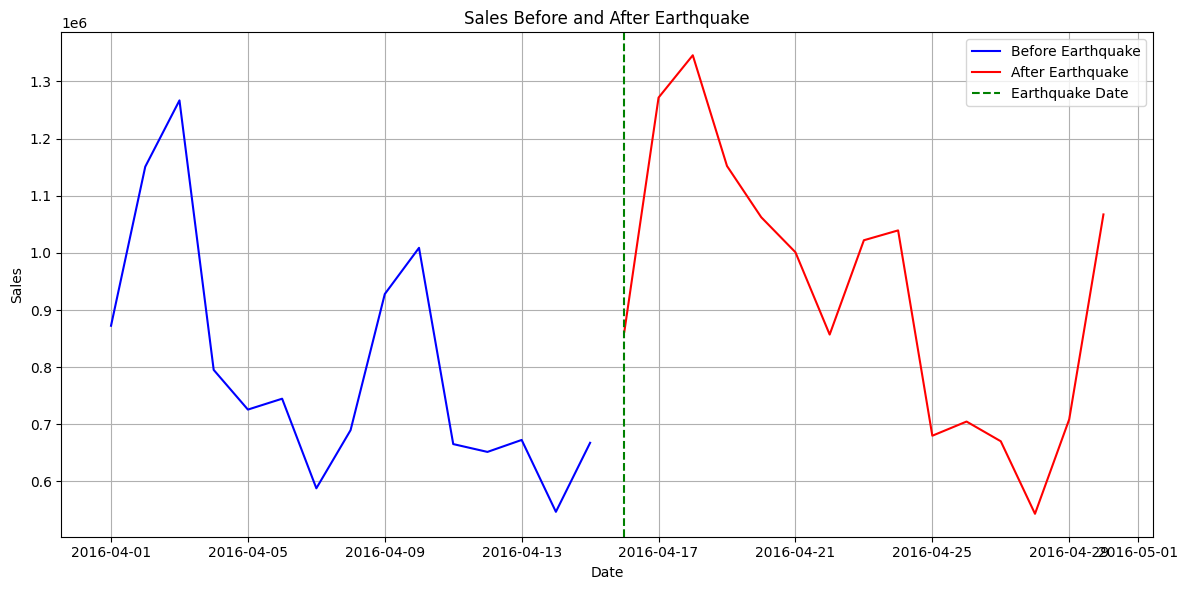

In [180]:
# Focusing on just April sales 
april_sales = sales_df[(sales_df['date'] >= '2016-04-01') & (sales_df['date'] <= '2016-04-30')]

# Filter data for the period before and after the earthquake
earthquake_date = "2016-04-16"
post_earthquake = april_sales[april_sales['date'] >= earthquake_date]
pre_earthquake = april_sales[april_sales['date'] < earthquake_date]

plt.figure(figsize=(12,6))
# Spliting the data into pre and post-earthquake periods
sns.lineplot(data=pre_earthquake, x='date', y='sales', label='Before Earthquake', color='blue')
sns.lineplot(data=post_earthquake, x='date', y='sales', label='After Earthquake', color='red')

# Create a line plot to visualize sales before and after the earthquake
plt.axvline(pd.to_datetime(earthquake_date), color='green', linestyle='--', label='Earthquake Date')

plt.title("Sales Before and After Earthquake")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)**

In [85]:
# Dispaly stores_df
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [86]:
# Dispaly df
df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1


In [87]:
# Merge on a common column 'store_nbr'
merged_df = pd.merge(df, stores_df, on='store_nbr', how='inner')
merged_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,city,state,type,cluster
0,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Quito,Pichincha,D,13
1,42,CELEBRATION,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
2,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
3,42,BOOKS,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
4,42,BEVERAGES,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2


In [88]:
merged_df['state'].unique()

array(['Pichincha', 'Azuay', 'El Oro', 'Esmeraldas', 'Guayas', 'Loja',
       'Manabi', 'Tungurahua', 'Santo Domingo de los Tsachilas',
       'Los Rios', 'Bolivar', 'Imbabura', 'Cotopaxi', 'Chimborazo',
       'Pastaza', 'Santa Elena'], dtype=object)

**Sales by state**

In [89]:
sales_by_state = merged_df.groupby(['state'])['sales'].sum().reset_index().sort_values(by='sales', ascending=False)
sales_by_state

,state,sales
12,Pichincha,585067395.31
6,Guayas,165154392.38
0,Azuay,49168596.03
15,Tungurahua,40304401.30
14,Santo Domingo de los Tsachilas,35834323.04
4,El Oro,33386796.54
9,Los Rios,31925373.99
10,Manabi,24969820.13
3,Cotopaxi,21182263.78
8,Loja,18859999.26


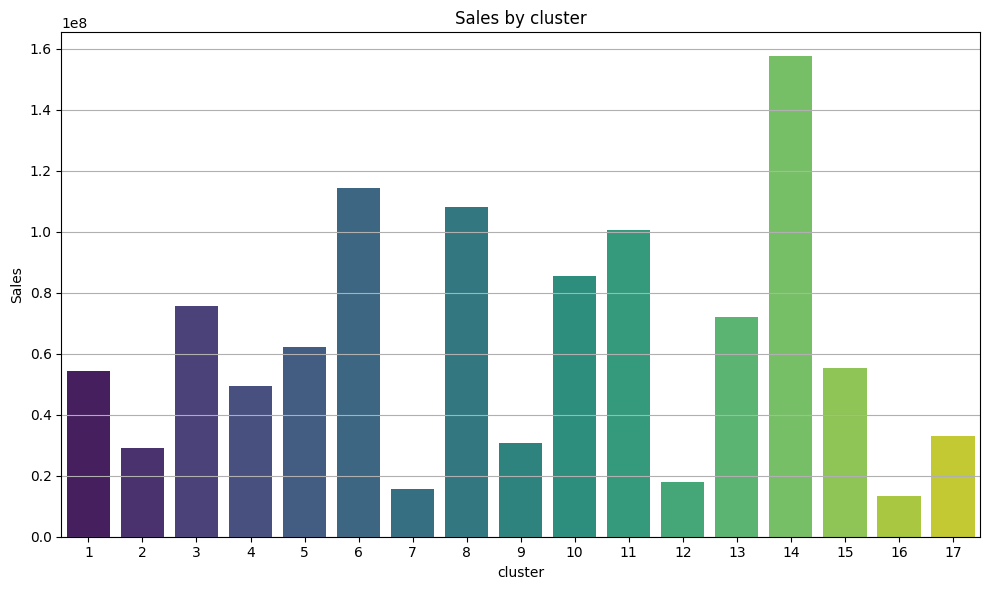

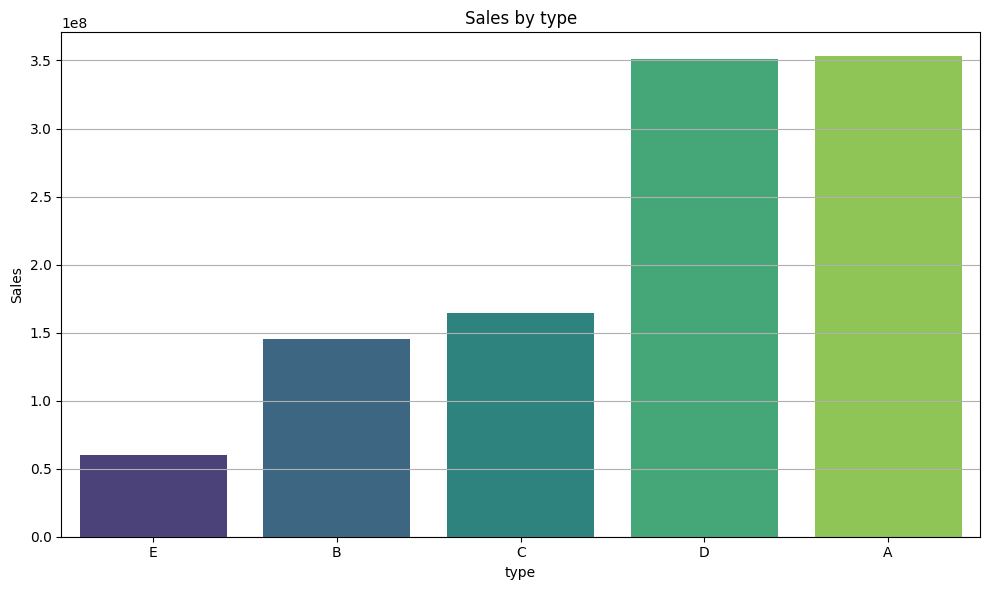

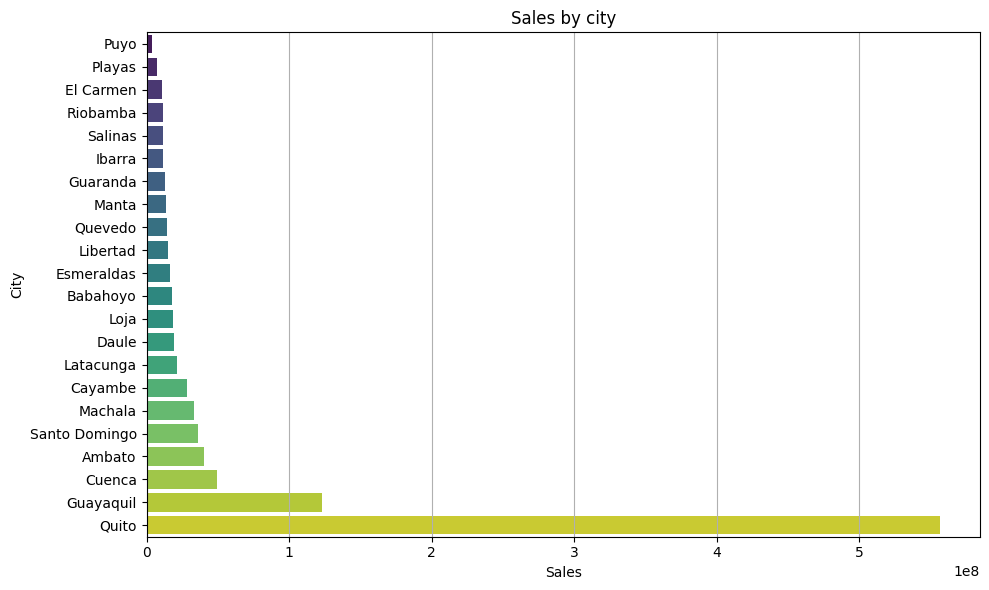

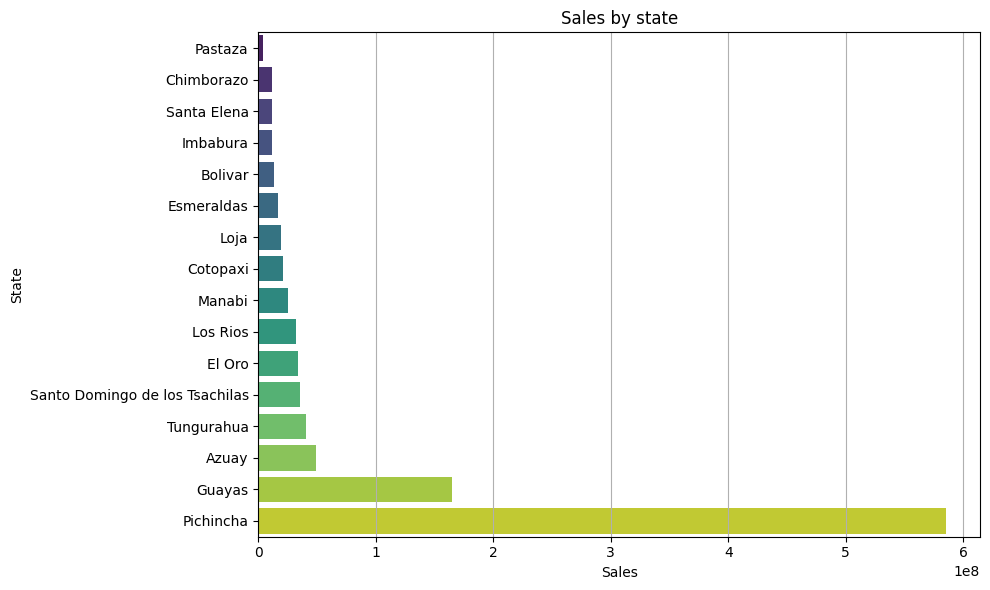

In [94]:
# Visualizing sales by each group
for group in ['cluster', 'type']:
    plt.figure(figsize=(10, 6))
    aggregated_data = merged_df.groupby(group)['sales'].sum().sort_values()
    sns.barplot(x=aggregated_data.index, y=aggregated_data.values, palette="viridis")
    
    plt.title(f"Sales by {group}")
    plt.ylabel('Sales')
    plt.xlabel(group)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
# Visualizing sales by city and state with horizontal bar plots
for group in ['city', 'state']:
    plt.figure(figsize=(10, 6))
    aggregated_data = merged_df.groupby(group)['sales'].sum().sort_values()
    sns.barplot(y=aggregated_data.index, x=aggregated_data.values, palette="viridis", orient='h')
    
    plt.title(f"Sales by {group}")
    plt.xlabel('Sales')
    plt.ylabel(group.capitalize())
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

**6. Are sales affected by promotions, oil prices and holidays?**

Promotion Analysis

In [172]:
# Filter out promotion with 0 values
no_promotion_df = df[df['onpromotion']== 0]

# Format with commas using an f-string
no_promotion_datapoints = f'{no_promotion_df.shape[0]:,}'
print(f'Number of datapoints with no promotion is {no_promotion_datapoints}')

Number of datapoints with no promotion is 2,396,687


In [163]:
# Filter out promotion with actual 
promotion_df = df[df['onpromotion'] > 0]

# Format with commas using an f-string
promotion_datapoints = f'{promotion_df.shape[0]:,}'
print(f'Number of datapoints with promotion is {promotion_datapoints}')

Number of datapoints with promotion is 611,329


In [174]:
no_promotion_df = no_promotion_df.groupby('family')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

# Add thousand separators to 'sales' column
no_promotion_df['sales_format'] = no_promotion_df['sales'].apply(lambda x: f'{x:,.0f}')
no_promotion_df = no_promotion_df.nlargest(10, 'sales')
no_promotion_df

,family,sales,sales_format
12,GROCERY I,92538393.70,"92,538,394"
3,BEVERAGES,50697146.00,"50,697,146"
30,PRODUCE,47646514.14,"47,646,514"
7,CLEANING,35634773.00,"35,634,773"
28,POULTRY,22319444.02,"22,319,444"
8,DAIRY,21567990.00,"21,567,990"
24,MEATS,21054436.99,"21,054,437"
5,BREAD/BAKERY,19749869.49,"19,749,869"
25,PERSONAL CARE,11641426.00,"11,641,426"
9,DELI,11411278.33,"11,411,278"


In [176]:
promotion_df = promotion_df.groupby('family')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

# Add thousand separators to 'sales' column
promotion_df['sales_format'] = promotion_df['sales'].apply(lambda x: f'{x:,.0f}')
promotion_df = promotion_df.nlargest(10, 'sales')
promotion_df

,family,sales,sales_format
11,GROCERY I,250924341.19,"250,924,341"
3,BEVERAGES,166257340.00,"166,257,340"
29,PRODUCE,75058170.54,"75,058,171"
6,CLEANING,61886516.00,"61,886,516"
7,DAIRY,42919719.00,"42,919,719"
4,BREAD/BAKERY,22384076.09,"22,384,076"
24,PERSONAL CARE,12950625.00,"12,950,625"
8,DELI,12699044.14,"12,699,044"
17,HOME CARE,10068717.00,"10,068,717"
23,MEATS,10032031.41,"10,032,031"


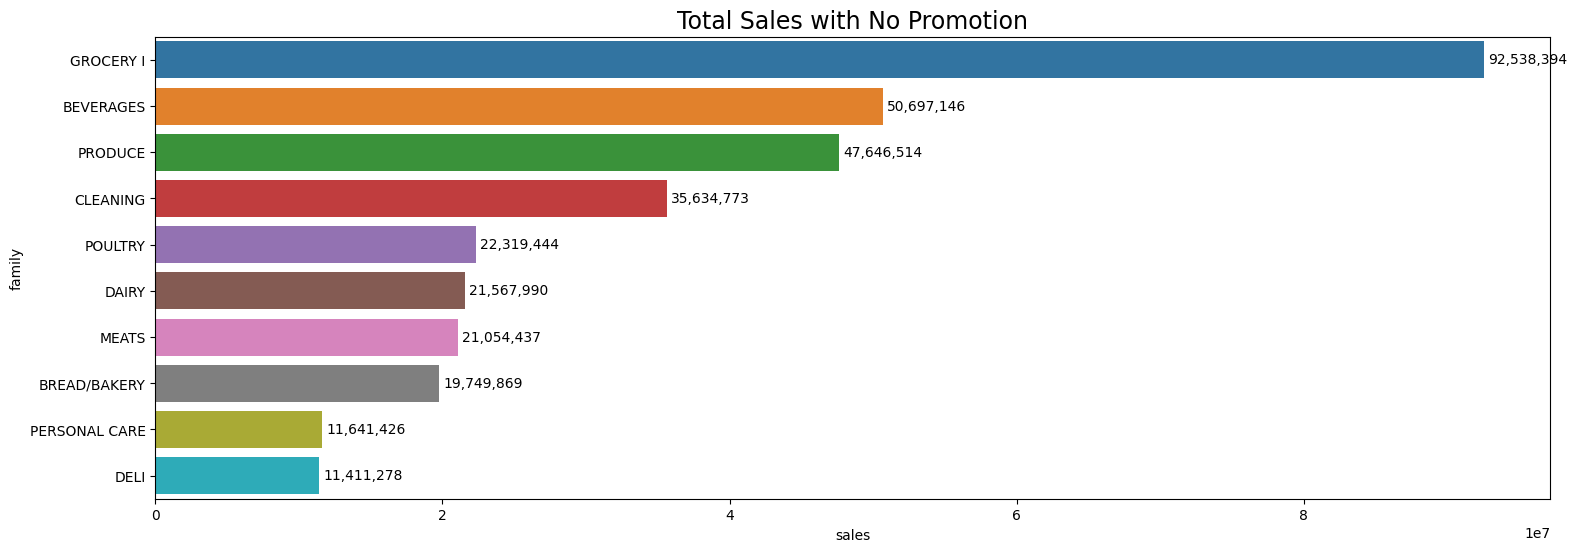

In [177]:
# Generate the plot 
plt.figure(figsize=(18, 6))
ax = sns.barplot(data=no_promotion_df, x='sales', y='family', palette='tab10')

# Add bar labels with thousand separators and padding visibilty
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', padding=3) # Ensure labels have thousands separators

plt.title('Total Sales with No Promotion', fontsize=17)
plt.show()

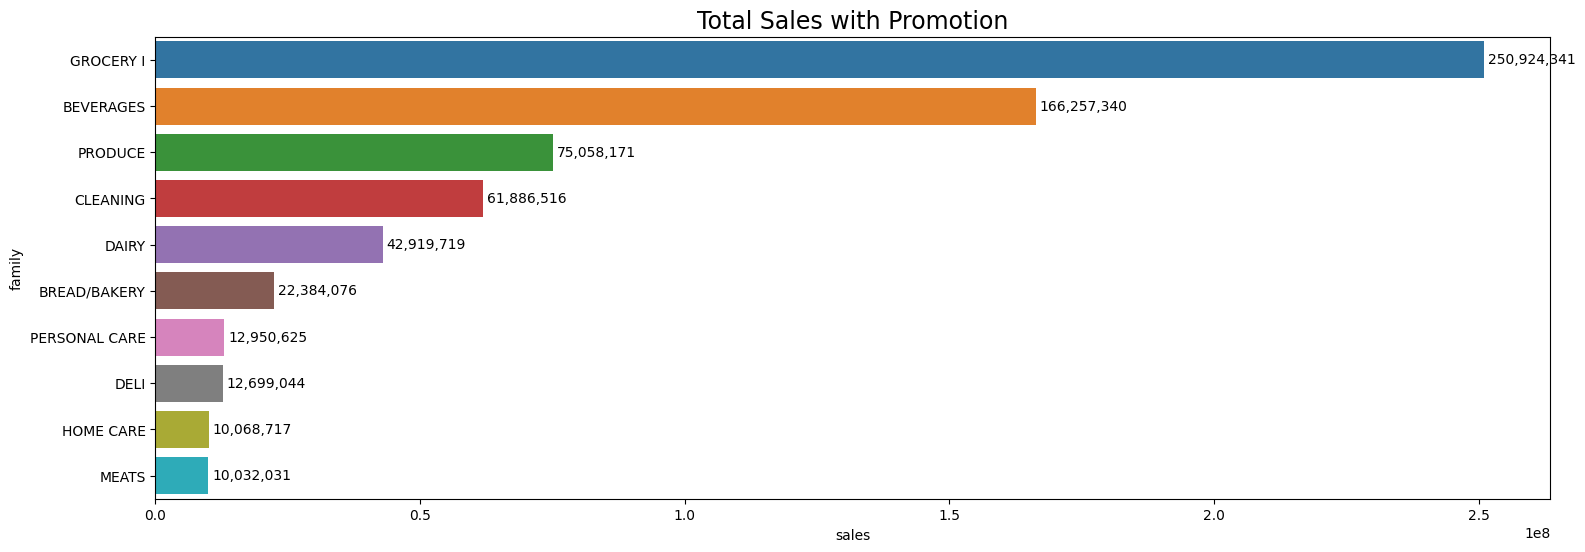

In [178]:
# Generate the plot 
plt.figure(figsize=(18, 6))
ax = sns.barplot(data=promotion_df, x='sales', y='family', palette='tab10')

# Add bar labels with thousand separators and padding visibilty
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', padding=3) # Ensure labels have thousands separators

plt.title('Total Sales with Promotion', fontsize=17)
plt.show()

Oil Prices Analysis

In [98]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [100]:
# Set date as index
oil_df.set_index('date', inplace=True)

In [101]:
# Confirm changes 
oil_df.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [102]:
# The range of the oil data
oil_start_date = oil_df.index.min()
oil_end_date = oil_df.index.max()

print(f'Oil start date is  {oil_start_date}')
print(f'Oil end date is  {oil_end_date}')

Oil start date is  2013-01-01 00:00:00
Oil end date is  2017-08-31 00:00:00


In [103]:
# Check for earliest and latest date
actual_date = train_df1['date'].min(), train_df1['date'].max()
print(f'Start date of data: {actual_date[0]}\nEnd date of data: {actual_date[1]}')

Start date of data: 2013-01-01 00:00:00
End date of data: 2017-08-15 00:00:00


In [108]:
date_range.size

1688

In [104]:
oil_df.size

1218

In [107]:
# Find the missing days from the date column 
missing_oil_dates = date_range.difference(oil_df.index)
print(f'Total missing days: {missing_oil_dates.nunique()}')
missing_oil_dates

Total missing days: 482


DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-15', '2017-07-16', '2017-07-22', '2017-07-23',
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13'],
              dtype='datetime64[ns]', length=482, freq=None)

In [118]:
# Create a dataframe of the the missing days 
missing_days_df = pd.DataFrame(missing_oil_dates, columns = ['date'])
missing_days_df.head()

,date
0,2013-01-05
1,2013-01-06
2,2013-01-12
3,2013-01-13
4,2013-01-19


In [119]:
# Find out what days of the week are missing 
missing_days_df['Day of the Week'] = missing_days_df['date'].apply(lambda x: x.strftime('%A'))
missing_days_df.set_index('date', inplace=True)

In [114]:
# Dispaly dataframe
missing_days_df.head()

,Day of the Week
date,
2013-01-05,Saturday
2013-01-06,Sunday
2013-01-12,Saturday
2013-01-13,Sunday
2013-01-19,Saturday


In [120]:
missing_days_df['Day of the Week'].unique()

array(['Saturday', 'Sunday'], dtype=object)

- Missing oil data happens to be Saturdays and Sunday
- This means oil prices are not recorded on weekends
- Forward fill method will be used fill the missing values i.e Friday prices will be used as commodity exchanges do not open during the weekend

In [121]:
# Oil prices missing from the original dataset 
oil_df.isna().sum()

dcoilwtico    43
dtype: int64

In [122]:
# Oil prices missing from the missing days df 
missing_days_df.isna().sum()

Day of the Week    0
dtype: int64

In [123]:
# All oil prices 
full_oil_data = pd.concat([oil_df, missing_days_df])
full_oil_data.isna().sum()

dcoilwtico          525
Day of the Week    1218
dtype: int64

In [126]:
# Drop 'Day of the Week '
full_oil_data.drop('Day of the Week', axis=1, inplace=True)
full_oil_data

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-07-30,NaN
2017-08-05,NaN
2017-08-06,NaN


In [127]:
# Forward fill NaN values 
full_oil_data['dcoilwtico'] = full_oil_data['dcoilwtico'].fillna(method='ffill')
full_oil_data.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [128]:
# Confirm changes 
full_oil_data.isnull().sum()

dcoilwtico    1
dtype: int64

In [129]:
full_oil_data.loc['2013-01-01']

dcoilwtico   NaN
Name: 2013-01-01 00:00:00, dtype: float64

In [130]:
# Fill NaN value for '2013-01-01'
full_oil_data.loc['2013-01-01'] = 93.14

In [131]:
# Confirm changes 
full_oil_data.isnull().sum()

dcoilwtico    0
dtype: int64

In [132]:
excess_oil_days = full_oil_data[full_oil_data.index > '2017-08-15']
excess_oil_days

,dcoilwtico
date,
2017-08-16,46.80
2017-08-17,47.07
2017-08-18,48.59
2017-08-21,47.39
2017-08-22,47.65
2017-08-23,48.45
2017-08-24,47.24
2017-08-25,47.65
2017-08-28,46.40


In [133]:
# Drop excess days from the oil data since it has about 2 weeks more data than the Train data set 
full_oil_data_df = full_oil_data.drop(excess_oil_days.index, axis=0)
full_oil_data_df

,dcoilwtico
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-07-30,47.26
2017-08-05,47.26
2017-08-06,47.26


In [134]:
# Rename column
full_oil_data_df = full_oil_data_df.rename(columns={'dcoilwtico' : 'oil_price'})
full_oil_data_df

,oil_price
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-07-30,47.26
2017-08-05,47.26
2017-08-06,47.26


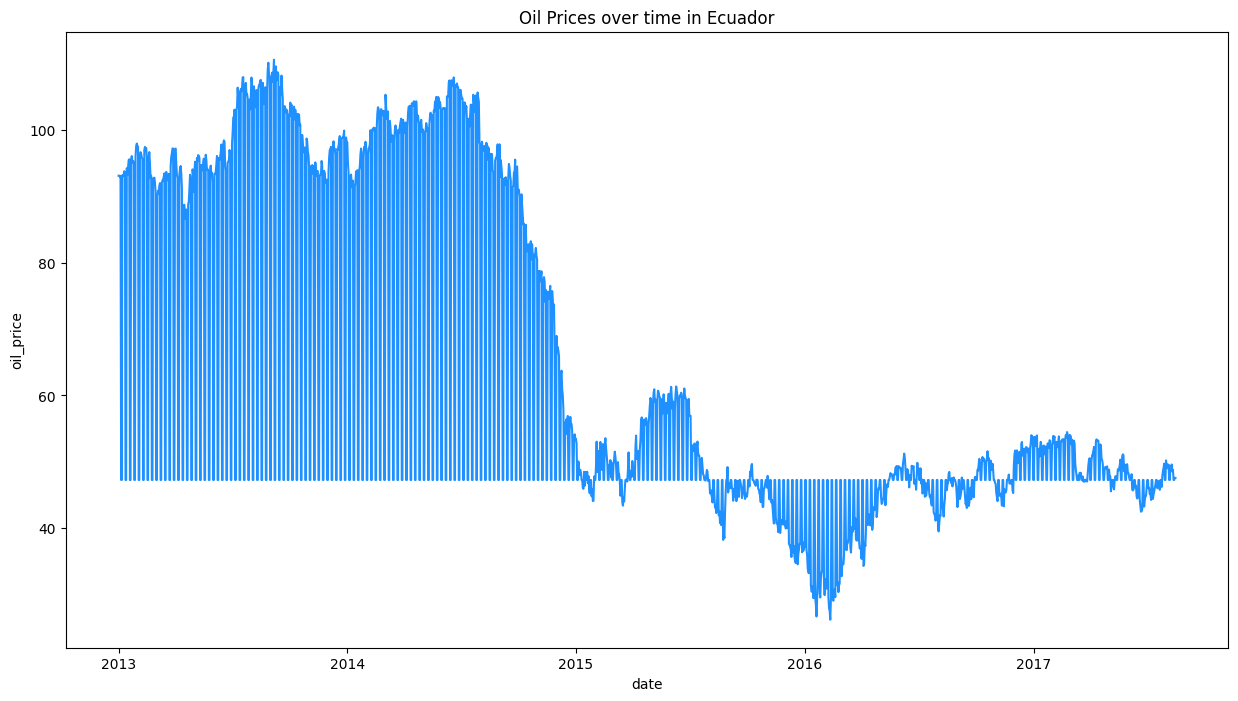

In [136]:
# View the oil price over time 
sns.lineplot(data=full_oil_data_df, x=full_oil_data_df.index, y='oil_price', color='dodgerblue')
plt.title('Oil Prices over time in Ecuador')
plt.show()

In [141]:
# Merge the cleaned oil data with cleaned train data
merged_with_oil_df = pd.merge(df, full_oil_data_df, on='date', how='inner')
merged_with_oil_df

,store_nbr,family,sales,onpromotion,month_name,month,year,day,oil_price
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,93.14
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,93.14
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,93.14
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,93.14
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,93.14
...,...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,1,47.57
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,1,47.57
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,1,47.57


In [142]:
# Group by the date and oil prices 
sales_by_oil_data = merged_with_oil_df.groupby(['date', 'oil_price'])['sales'].sum().reset_index()
sales_by_oil_data

,date,oil_price,sales
0,2013-01-01,93.14,2511.62
1,2013-01-02,93.14,496092.42
2,2013-01-03,92.97,361461.23
3,2013-01-04,93.12,354459.68
4,2013-01-05,47.26,477350.12
...,...,...,...
1683,2017-08-11,48.81,826373.72
1684,2017-08-12,47.26,792630.54
1685,2017-08-13,47.26,865639.68
1686,2017-08-14,47.59,760922.41


In [145]:
# Select the 7 highest oil price - a week of data
high_oil_prices = sales_by_oil_data.nlargest(7, 'oil_price')
high_oil_prices['price_category'] = 'High'
high_oil_prices

,date,oil_price,sales,price_category
248,2013-09-06,110.62,335442.25,High
239,2013-08-28,110.17,319322.06,High
251,2013-09-09,109.62,377151.71,High
238,2013-08-27,109.11,319688.22,High
254,2013-09-12,108.72,282855.73,High
245,2013-09-03,108.67,397680.42,High
240,2013-08-29,108.51,294518.69,High


In [147]:
# Select the 7 lowest oil price - a week of data
low_oil_prices = sales_by_oil_data.nsmallest(7, 'oil_price')
low_oil_prices['price_category'] = 'Low'
low_oil_prices

,date,oil_price,sales,price_category
1136,2016-02-11,26.19,646376.37,Low
1114,2016-01-20,26.68,738744.01,Low
1135,2016-02-10,27.54,790988.71,Low
1134,2016-02-09,27.96,746939.64,Low
1113,2016-01-19,28.47,630929.75,Low
1141,2016-02-16,29.05,719111.89,Low
1137,2016-02-12,29.32,698152.07,Low


In [149]:
oil_merged_df = pd.concat([high_oil_prices, low_oil_prices])
oil_merged_df

,date,oil_price,sales,price_category
248,2013-09-06,110.62,335442.25,High
239,2013-08-28,110.17,319322.06,High
251,2013-09-09,109.62,377151.71,High
238,2013-08-27,109.11,319688.22,High
254,2013-09-12,108.72,282855.73,High
245,2013-09-03,108.67,397680.42,High
240,2013-08-29,108.51,294518.69,High
1136,2016-02-11,26.19,646376.37,Low
1114,2016-01-20,26.68,738744.01,Low
1135,2016-02-10,27.54,790988.71,Low


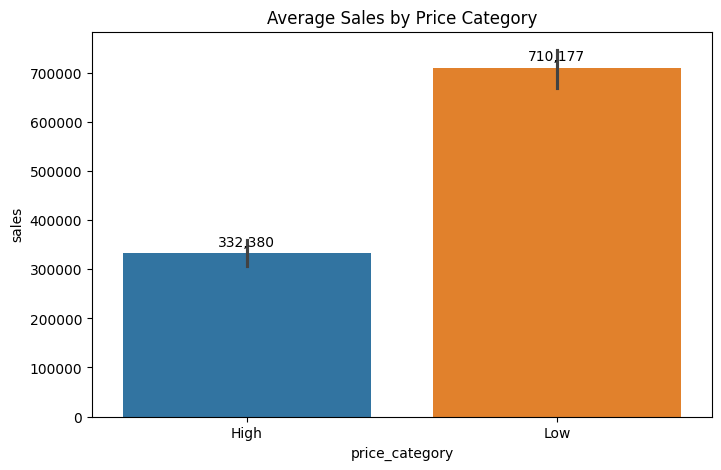

In [154]:
# Plot out te average sales for high and low oil price days 
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=oil_merged_df, x='price_category', y='sales', hue='price_category')

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', padding=3)

plt.title('Average Sales by Price Category')
plt.show()

Holiday Analysis

**7. What analysis can we get from the date and its extractable features?**

**8. Which product family and stores did the promotions affect.**

**9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)**

**10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.**

### Hypothesis Testing
Null Hypothesis (H0): The promotional activities have a significant impact on sales for Corporation Favorita.

Alternative Hypothesis (H1): The promotional activities have a significant impact on sales for Corporation Favorita.

In [195]:
from scipy.stats import ttest_ind

# Extract the relevant variables for the hypothesis test
promo_sales = df[df['onpromotion'] == 1]['sales']
non_promo_sales = df[df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): The promotional activities do not have a significant impact on sales.")
print("Alternative Hypothesis (H1): The promotional activities have a significant impact on sales.")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis. Promotional activities have a significant impact on sales at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. Promotional activities do not have a significant impact on sales at Corporation Favorita.")


Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): The promotional activities do not have a significant impact on sales.
Alternative Hypothesis (H1): The promotional activities have a significant impact on sales.
--------------------------------------------------
Test Statistic: 193.83484871288806
P-value: 0.0
Reject the null hypothesis. Promotional activities have a significant impact on sales at Corporation Favorita.


Based on the hypothesis test, we obtained a very low p-value of 0.0. This indicates strong evidence to reject the null hypothesis. Therefore, we can conclude that promotional activities have a significant impact on sales for Corporation Favorita. The test statistic of 193.83 also suggests a substantial difference in sales between promotional and non-promotional periods. These results support the notion that promotional activities play a crucial role in driving sales.


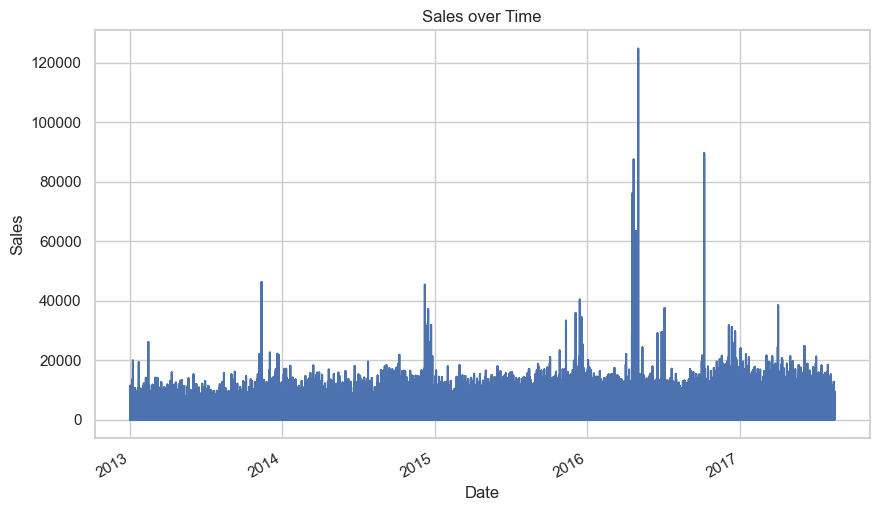

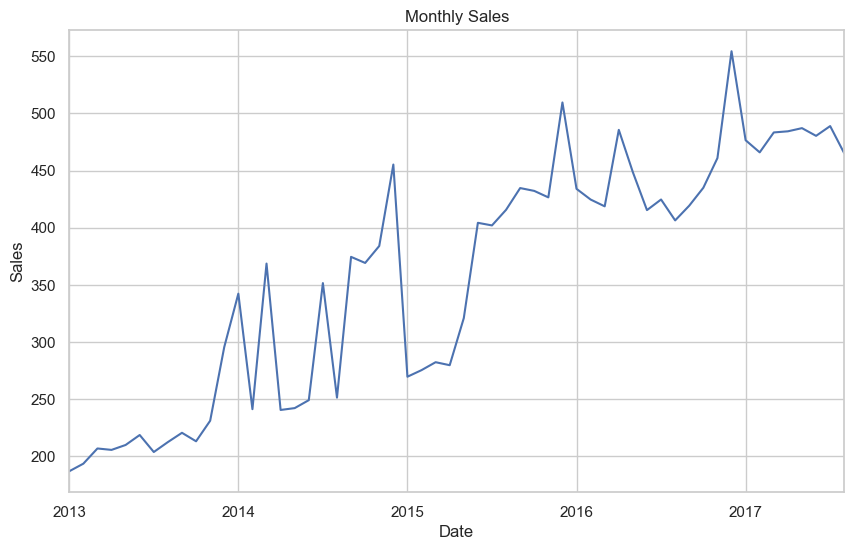

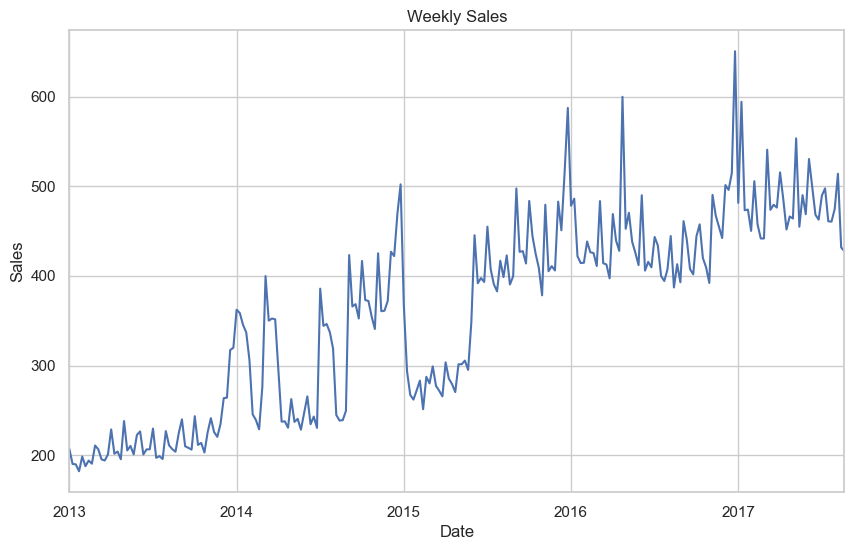

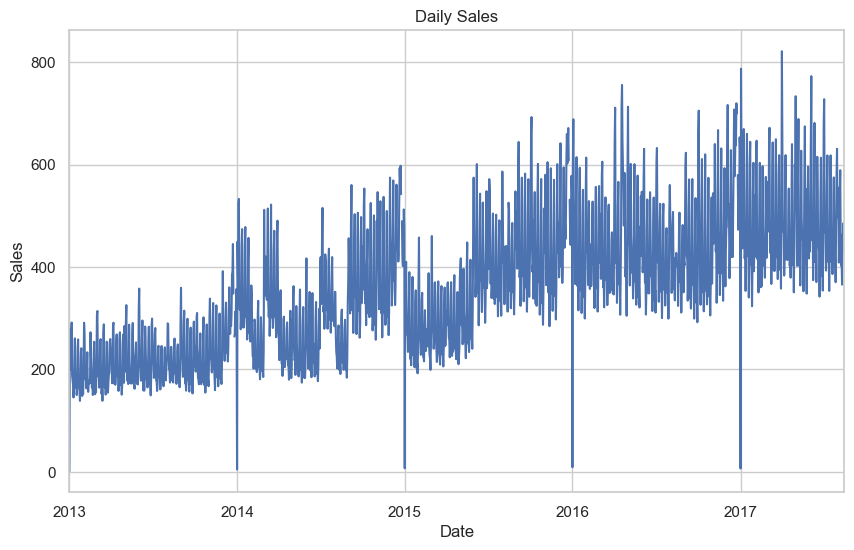

In [30]:
# Exploring sales column
plt.figure(figsize=(10, 6))
train_df1.sales.plot()
plt.title("Sales over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Monthly resampling
sale_monthly = train_df1["sales"].resample("M").mean()

plt.figure(figsize=(10, 6))
plt.title("Monthly Sales")
sale_monthly.plot()
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Weekly resampling
sale_weekly = train_df1["sales"].resample("W").mean()

plt.figure(figsize=(10, 6))
plt.title("Weekly Sales")
sale_weekly.plot()
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Daily resampling
sale_daily = train_df1["sales"].resample("D").mean()

plt.figure(figsize=(10, 6))
plt.title("Daily Sales")
sale_daily.plot()
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

## **Data Preparation**

## **Modelling**

## **Evaluation**